## Семинар 9: "LSTM"

ФИО: Салихова Кария Илшатовна

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

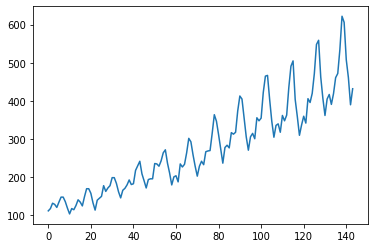

In [106]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [107]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [108]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=0):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [109]:
def create_data(seq_len, b_size):
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size:], dataset[train_size-seq_len:train_size:]
    
    look_back = seq_len
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
    train_dataloader =  DataLoader(train_dataset, batch_size=b_size, shuffle=True)
    
    test_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
    test_dataloader =  DataLoader(train_dataset, batch_size=b_size)
    return train, test, trainX, trainY, testX, testY, train_dataset, train_dataloader, test_dataset, test_dataloader

In [191]:
look_back = 25
train, test, trainX, trainY, testX, testY, train_dataset, train_dataloader, test_dataset, test_dataloader = create_data(look_back, 50)

In [156]:
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pad_packed_sequence

class Model1(nn.Module):
    def __init__(self, hidden_size, input_size = 1, num_layers = 1):
        super(Model1, self).__init__()
        self.inp_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.model = nn.LSTM(self.inp_size, self.hidden_size, num_layers)
        self.to_out = nn.Linear(self.hidden_size, 1)
        
    def forward(self, input_batch):
        input_size = input_batch.size(0)
        hidden = (torch.zeros(self.num_layers, input_size, self.hidden_size),
                  torch.zeros(self.num_layers, input_batch.size(0), self.hidden_size))
        input_batch = pack_sequence(input_batch)
        res1, self.hidden = self.model(input_batch, hidden)
        res1, _ = pad_packed_sequence(res1, False)
        res2 = self.to_out(res1[-1].view(input_size, self.hidden_size))
        return res2
    
def get_prediction(model, X_test, torch_model = True):
    res = []
    for i in range(test_size):
        y_test = model(X_test)
        res.append(y_test[-1].detach().numpy()[0])
        if torch_model:
            X_test = torch.cat((X_test[:,1:,:], y_test.view(1, 1, 1)), 1)
        else:
            X_test = torch.cat((X_test[1:,:,:], y_test.view(1, 1, 1)), 0)
    return res

In [157]:
nn_model = Model1(8)

In [158]:
optim = torch.optim.Adam(nn_model.parameters(), lr = 1e-2)
num_epoch = 1500
res_plot = np.zeros(num_epoch)
Loss = nn.MSELoss()

for i in range(num_epoch):
    losses = []
    for train_X, train_Y in train_dataloader:
        nn_model.zero_grad()
        train_X = torch.FloatTensor(train_X).view(-1, look_back, 1)
        train_Y = torch.FloatTensor(train_Y).view(-1, 1)
        res = nn_model(train_X)
        loss = Loss(res, train_Y)
        losses.append(loss.data.item())
        loss.backward()
        optim.step()
        res_plot[i] = np.mean(losses)
    #clear_output(True)
    if i%100 == 0:
        print('\rEpoch {0}... \tMSE: {1:.3e}'.format(i, res_plot[i]))

Epoch 0... 	MSE: 1.548e-02
Epoch 100... 	MSE: 1.659e-03
Epoch 200... 	MSE: 1.214e-03
Epoch 300... 	MSE: 5.639e-04
Epoch 400... 	MSE: 4.957e-04
Epoch 500... 	MSE: 4.218e-04
Epoch 600... 	MSE: 3.265e-04
Epoch 700... 	MSE: 2.588e-04
Epoch 800... 	MSE: 2.497e-04
Epoch 900... 	MSE: 2.422e-04
Epoch 1000... 	MSE: 1.722e-04
Epoch 1100... 	MSE: 1.124e-04
Epoch 1200... 	MSE: 3.268e-04
Epoch 1300... 	MSE: 8.444e-05
Epoch 1400... 	MSE: 5.690e-05


Text(0.5, 1.0, 'Loss')

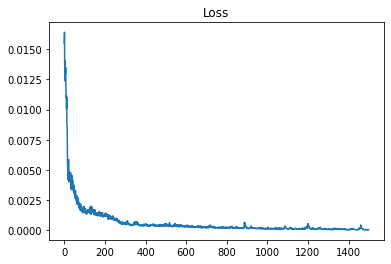

In [159]:
plt.plot(res_plot)
plt.title('Loss')

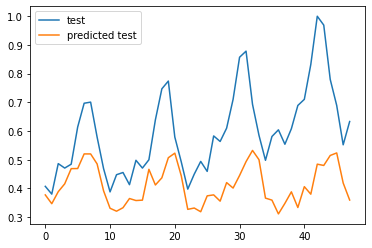

In [160]:
res = get_prediction(nn_model, torch.from_numpy(test).view(1, look_back, 1))
plt.plot(dataset[train_size:len(dataset):], label='test')
plt.plot(res, label='predicted test')
plt.legend(fontsize=10)

Как видим, LSTM из библиотеки показала хорошие результаты. Теперь запустим нашу LSTM на тех же условиях(learning rate, sequence len, num of epoch, batch size, hidden size).

In [161]:
class Model2(nn.Module):
    def __init__(self, hidden_size, input_size = 1):
        super(Model2, self).__init__()
        self.inp_size = input_size
        self.hidden_size = hidden_size
        self.model = LSTM(self.inp_size, self.hidden_size)
        self.to_out = nn.Linear(self.hidden_size, 1)
        
    def forward(self, input_batch):
        input_size = input_batch.size(1)
        hidden = (Variable(torch.zeros(input_size, self.hidden_size)),
                  Variable(torch.zeros(input_size, self.hidden_size)))
        
        res1, self.hidden = self.model(input_batch, hidden)
        res2 = self.to_out(res1[-1].view(input_size, self.hidden_size))
        return res2

In [162]:
my_model = Model2(8)

In [163]:
optim = torch.optim.Adam(my_model.parameters(), lr = 1e-2)
num_epoch = 1500
res_plot = np.zeros(num_epoch)
Loss = nn.MSELoss()

for i in range(num_epoch):
    losses = []
    for train_X, train_Y in train_dataloader:
        my_model.zero_grad()
        train_X = Variable(train_X.permute(1, 0).unsqueeze(-1))
        train_Y = Variable(train_Y)
        res = my_model(train_X).squeeze()
        #print(res.shape)
        #print(train_Y.shape)
        loss = Loss(res, train_Y)
        losses.append(loss.data.item())
        loss.backward()
        optim.step()
        res_plot[i] = np.mean(losses)
    #clear_output(True)
    if i%100 == 0:
        print('\rEpoch {0}... \tMSE: {1:.3e}'.format(i, res_plot[i]))

Epoch 0... 	MSE: 1.317e-02
Epoch 100... 	MSE: 4.219e-03
Epoch 200... 	MSE: 1.924e-03
Epoch 300... 	MSE: 1.978e-03
Epoch 400... 	MSE: 1.893e-03
Epoch 500... 	MSE: 1.526e-03
Epoch 600... 	MSE: 1.275e-03
Epoch 700... 	MSE: 1.213e-03
Epoch 800... 	MSE: 7.957e-04
Epoch 900... 	MSE: 6.646e-04
Epoch 1000... 	MSE: 4.586e-04
Epoch 1100... 	MSE: 3.089e-04
Epoch 1200... 	MSE: 3.243e-04
Epoch 1300... 	MSE: 1.747e-04
Epoch 1400... 	MSE: 1.518e-04


Text(0.5, 1.0, 'Loss')

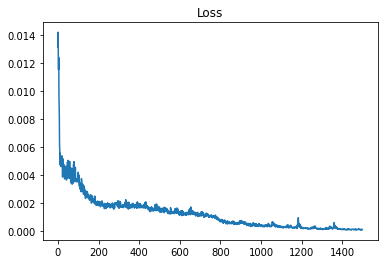

In [164]:
plt.plot(res_plot)
plt.title('Loss')

Сходимость по-прежнему хорошая, а результаты получились плохие: 

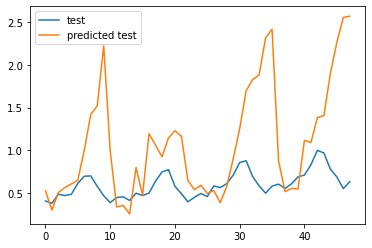

In [165]:
res = get_prediction(my_model, torch.from_numpy(test).view(look_back, 1, 1), False)
plt.plot(dataset[train_size:len(dataset):], label='test')
plt.plot(res, label='predicted test')
plt.legend()

Теперь попробуем увеличить hidden size, а также увеличим количество эпох:

In [192]:
my_model = Model2(12)

In [193]:
optim = torch.optim.Adam(my_model.parameters(), lr = 1e-2)
num_epoch = 2000
res_plot = np.zeros(num_epoch)
Loss = nn.MSELoss()

for i in range(num_epoch):
    losses = []
    for train_X, train_Y in train_dataloader:
        my_model.zero_grad()
        train_X = Variable(train_X.permute(1, 0).unsqueeze(-1))
        train_Y = Variable(train_Y)
        res = my_model(train_X).squeeze()
        #print(res.shape)
        #print(train_Y.shape)
        loss = Loss(res, train_Y)
        losses.append(loss.data.item())
        loss.backward()
        optim.step()
        res_plot[i] = np.mean(losses)
    #clear_output(True)
    if i%100 == 0:
        print('\rEpoch {0}... \tMSE: {1:.3e}'.format(i, res_plot[i]))

Epoch 0... 	MSE: 2.622e-02
Epoch 100... 	MSE: 2.000e-03
Epoch 200... 	MSE: 2.083e-03
Epoch 300... 	MSE: 1.830e-03
Epoch 400... 	MSE: 1.153e-03
Epoch 500... 	MSE: 5.840e-04
Epoch 600... 	MSE: 5.212e-04
Epoch 700... 	MSE: 3.693e-04
Epoch 800... 	MSE: 3.370e-04
Epoch 900... 	MSE: 3.666e-04
Epoch 1000... 	MSE: 3.409e-04
Epoch 1100... 	MSE: 2.554e-04
Epoch 1200... 	MSE: 2.051e-04
Epoch 1300... 	MSE: 1.640e-04
Epoch 1400... 	MSE: 1.761e-04
Epoch 1500... 	MSE: 9.880e-05
Epoch 1600... 	MSE: 7.557e-05
Epoch 1700... 	MSE: 1.062e-04
Epoch 1800... 	MSE: 5.236e-05
Epoch 1900... 	MSE: 2.962e-05


Text(0.5, 1.0, 'Loss')

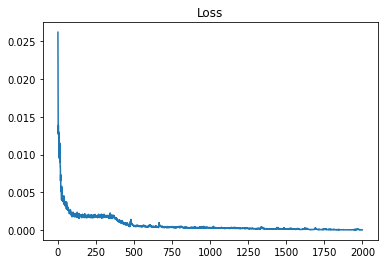

In [194]:
plt.plot(res_plot)
plt.title('Loss')

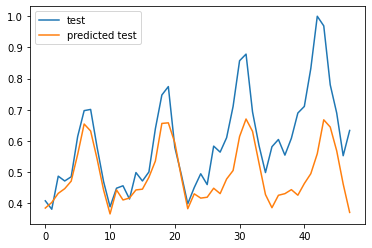

In [195]:
res = get_prediction(my_model, torch.from_numpy(test).view(look_back, 1, 1), False)
plt.plot(dataset[train_size:len(dataset):], label='test')
plt.plot(res, label='predicted test')
plt.legend(fontsize=10)

Как видим, результаты улучшились - теперь модель распознает "пики". Но результаты работы LSTM из PyTorch по-прежнему лучше, при этом при меньшем количестве скрытых слоев и эпох.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: